In [1]:
# imports
import os
import glob
import pandas as pd
import random as random
import numpy as np
import obspy
from obspy.core import read
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

In [2]:
signalmodel = load_model('signalmodelCNN_v3')
locmodel = load_model('locmodelCNN_v3')

Metal device set to: Apple M1


2022-03-16 11:53:49.898813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-16 11:53:49.899062: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
def predict(trace):
    
    ## Things to Specify -- Ensure that they align with trained model
    # For rolling averages
    roll_short = 25
    roll_long = 50

    # For location segments
    window_step = 20
    window_size = 20
    
    # Step size for CNN
    n_steps_sig = 3
    n_steps_loc = 2
    
    # Probability cut-offs
    #p_prob = p_prob # for p-wave
    #s_prob = s_prob # for signal
    
    ## Reading in Trace and Splitting Channels
    sig_trace = trace.normalize()
    
    samp_rate = sig_trace.stats.sampling_rate
    start_time = sig_trace.stats.starttime
    
    sigs = sig_trace.data
    
    sig_df = pd.DataFrame(sigs, columns = ["trace"])
    
    sigfeatures = []
    
    ## Calculating various features needed for the signal model
    tr = sig_df["trace"]
    mag = abs(tr)
    d = {"trace":tr, "magnitude":mag}
    temp_df = pd.DataFrame(data = d)
    
    temp_df["STA"] = temp_df["magnitude"].rolling(roll_short).mean()
    temp_df["LTA"] = temp_df["magnitude"].rolling(roll_long).mean()
    temp_df["RAV"] = temp_df["STA"]/temp_df["LTA"]
    temp_df["STV"] = temp_df["magnitude"].rolling(roll_short).var()
    temp_df["LTV"] = temp_df["magnitude"].rolling(roll_long).var()

    temp_df.dropna(inplace = True)
    sigfeatures.append(temp_df.values)
    
    sigfeatures = np.array(sigfeatures)
    n_timesteps, n_features, n_outputs = sigfeatures.shape[1], sigfeatures.shape[2], 2
    n_length = int(n_timesteps/n_steps_sig)

    sigfeatures1 = sigfeatures.reshape((sigfeatures.shape[0], n_steps_sig, n_length, n_features))
    
    ## Predicting whether or not there is a pwave in the trace
    is_sig = signalmodel.predict(sigfeatures1)[0][1]

    locfeatures = []

    ## If there is a pwave in the trace, continue to find location of pwave
    start_ind = 0
    end_ind = start_ind + window_size

    while end_ind < (1000 - roll_long):
        trwindow = temp_df["trace"].iloc[start_ind:end_ind]
        magwindow = temp_df["magnitude"].iloc[start_ind:end_ind]
        ravwindow = temp_df["RAV"].iloc[start_ind:end_ind]
        stvwindow = temp_df["STV"].iloc[start_ind:end_ind]
        ltvwindow = temp_df["LTV"].iloc[start_ind:end_ind]

        window_data = {"trace": trwindow, "magnitude": magwindow,
                            "RAV": ravwindow, "STV": stvwindow, "LTV": ltvwindow}

        window_df = pd.DataFrame(data = window_data)

        locfeatures.append(window_df.values)

        start_ind += window_step
        end_ind = start_ind + window_size

    locfeatures = np.array(locfeatures)
    n_timesteps, n_features, n_outputs = locfeatures.shape[1], locfeatures.shape[2], 2
    n_length = int(n_timesteps/n_steps_loc)
    
    locfeatures1 = locfeatures.reshape((locfeatures.shape[0], n_steps_loc, n_length, n_features))
    
    
    prob_vec = locmodel.predict(locfeatures1)[:,1]
    
    # Since we know if there is a p-wave, it will be in the last 3 seconds:
    end_ind = len(prob_vec)
    beg_ind = len(prob_vec) - int(3*samp_rate/window_size + 1)
    p_segment = beg_ind + np.where(prob_vec[beg_ind:end_ind] == max(prob_vec[beg_ind:end_ind]))[0][0]
        
    tick_delta = p_segment*window_step + 0.5*window_size + (roll_long - 1)
        
    time_delta = (tick_delta)/samp_rate
    p_time = start_time + time_delta
    
    is_p = (max(prob_vec[beg_ind:end_ind]))
        
    #if (is_sig >= s_prob)|(max(prob_vec[beg_ind:end_ind]) > p_prob):
    
    return(p_time, is_sig, is_p)
            
    #else:
        #return None, is_sig, is_p

In [4]:
# get all filenames
datapath = "validation_data"
valid_filenames = [f for f in glob.glob(datapath + "/*/*")]
number_of_files = len(valid_filenames)
number_of_noise = len([f for f in valid_filenames if "_N" in f])
number_of_pwave = number_of_files-number_of_noise

In [5]:
def f1_samples(valid_filenames, seed):
    
    random.seed(seed)
    # set variables
    accuracy = .5 # max time difference in seconds
    p_win = (.5, 3) # setting limits for P-wave 
    sampling_rate = 31.25
    min_snr = 1.5
    
    answers = []
    predictions = []
    is_sigs = []
    is_ps = []
    
    for f in valid_filenames:

        # read in the file
        st = read(f)
        cut = int((random.random()*p_win[1]+p_win[0])*sampling_rate)

        # iterate over traces in mseed files
        for tr in st:

            # there was a comment raised during one of the sessions that some p-waves have very low signal-to-noise ratio
            # here I require all p-waves to have snr 1.5 or greater
            # snr is calcuated as a ratio of sums of abs values of waveforms 1s before and 1s after p-wave arrival
            snr = sum(abs(tr.data[1000:1032]))/sum(abs(tr.data[1000-32:1000]))

            # in case of small snr, just print a message
            if "_P" in f and snr<=min_snr:
                abc = 1
                #print("  Channel: {}, passing, not high-enough P wave S/N ratio ({:4.2f})".format(tr.stats.channel, snr))      

            # otherwise do everything
            else:
                tr.data = tr.data[cut:1000+cut]

                # set correct answers
                if "_N" in f:
                    # if it is a noise segment, the correct answer is None
                    correct_answer = None
                else:
                    # if it is a p-wave segment, the correct answer is the p-wave arrival time (UTCDateTime format)
                    correct_answer = tr.stats.starttime + (1000-cut)/tr.stats.sampling_rate

                prediction, is_sig, is_p = predict(tr)
                
                answers.append(correct_answer)
                predictions.append(prediction)
                is_sigs.append(is_sig)
                is_ps.append(is_p)

                
    
    return(answers, predictions, is_sigs, is_ps)

In [6]:
answer1, pred1, sigs1, ps1 = f1_samples(valid_filenames, 1)

2022-03-16 11:53:58.678723: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-16 11:53:58.851007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-16 11:53:59.228700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-16 11:54:00.798450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-16 11:54:00.874513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [7]:
answer5, pred5, sigs5, ps5 = f1_samples(valid_filenames, 5)

In [8]:
answer10, pred10, sigs10, ps10 = f1_samples(valid_filenames, 10)

In [9]:
answer17, pred17, sigs17, ps17 = f1_samples(valid_filenames, 17)

In [10]:
answer42, pred42, sigs42, ps42 = f1_samples(valid_filenames, 42)

In [11]:
def eval_thresh(correct_answer, prediction, sig_prob, p_prob, sig_thresh, p_thresh):
    n = len(correct_answer)
    accuracy = .5
    
    hit = 0; miss = 0; false_alarm = 0; correct_rejection = 0
    hit_accuracy = []
    
    for i in range(n):
        
        if (sig_prob[i] >= sig_thresh)|(p_prob[i] > p_thresh): 
            pred = prediction[i]
        else:
            pred = None
        
        if pred is None and correct_answer[i] is None:
            correct_rejection += 1

        # p-wave segment but no detection
        elif pred is None and correct_answer[i] is not None:
            miss += 1

        # p-wave falsely detected in noise segment
        elif pred is not None and correct_answer[i] is None:
            false_alarm += 1

        # p-wave detected in p-wave segment
        else:
            # evaluate if the detection is accurate enough, if so it is a hit...
            if abs(correct_answer[i]-pred) <= accuracy:
                hit += 1
                hit_accuracy.append(correct_answer[i]-pred)

            # ...else it is unfortunately a miss.
            else:
                miss += 1
                hit_accuracy.append(correct_answer[i]-pred)
    
    precision = hit/(hit+false_alarm)
    recall = hit/(hit+miss)
    f1score = (2*precision*recall)/(precision+recall)
    
    return f1score

In [12]:
s_probs = np.linspace(0.1, 0.5, 100)
p_probs = np.linspace(0.1, 0.5, 100)

In [26]:
f1_mat = []
x = [] #p_prob
y = [] #s_prob
z = [] #avg_f1
for s_prob in s_probs:
    for p_prob in p_probs:
        f_1 = eval_thresh(answer1, pred1, sigs1, ps1, s_prob, p_prob)
        f_5 = eval_thresh(answer5, pred5, sigs5, ps5, s_prob, p_prob)
        f_10 = eval_thresh(answer10, pred10, sigs10, ps10, s_prob, p_prob)
        f_17 = eval_thresh(answer17, pred17, sigs17, ps17, s_prob, p_prob)
        f_42 = eval_thresh(answer42, pred42, sigs42, ps42, s_prob, p_prob)
        
        
        avg_f1 = (f_1 + f_5 + f_10 + f_17 + f_42)/5
        f1_mat.append([p_prob, s_prob, avg_f1])
        x.append(p_prob)
        y.append(s_prob)
        z.append(avg_f1)

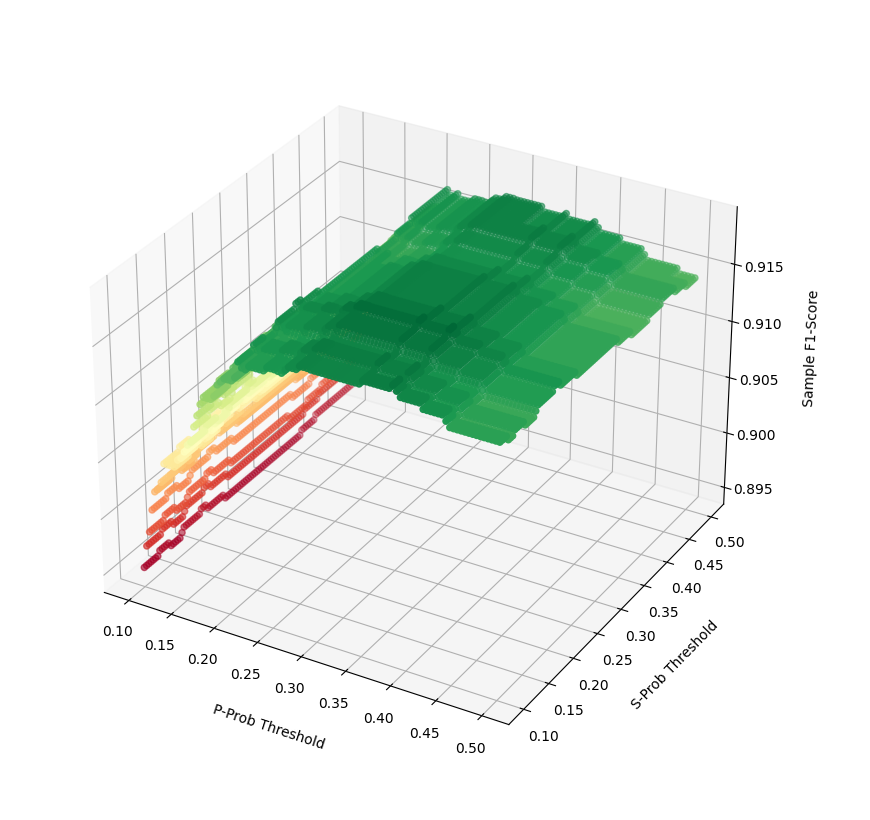

In [68]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9, 7.5] 
plt.rcParams["figure.autolayout"] = True 
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["xtick.major.pad"] = 5
plt.rcParams["axes.labelpad"] = 15
plt.rcParams["savefig.pad_inches"] = 0.5
plt.rcParams["savefig.transparent"] = True

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Data for three-dimensional scattered points
ax.scatter(x, y, z, c = z, cmap='RdYlGn')
ax.set_xlabel('P-Prob Threshold')
ax.set_ylabel('S-Prob Threshold')
ax.set_zlabel('Sample F1-Score')
plt.savefig("variation.png") 
plt.show()

In [18]:
x[np.argmax(z)]

0.3545454545454545

In [19]:
y[np.argmax(z)]

0.20505050505050504

In [20]:
z[np.argmax(z)]

0.9182695487515474